## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [16]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"
IMAGES_OUTPUT_FOLDER = "C:/Users/Killian/Desktop/Paper V2/Images/"
TEST_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Testing/"

## Defining Analysis Functions

In [3]:
def import_data(model_name="univariate_baseline", just_preds=False, mb=True):
    if just_preds:
        predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
        if mb:
            return predicted/1024
        return predicted
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    if mb:
        return true/1024, predicted/1024
    return true, predicted

In [4]:
def get_variance(data):
    return np.var(data)

In [5]:
def get_std(data):
    return np.std(data)

In [6]:
def get_ts_residuals(true, pred):
        residuals = true-pred
        return residuals

In [7]:
import seaborn as sns
def time_step_boxplots(residuals=[], model_names=[], title="", xlim=(), savefig_path="", xlab="Residuals (Mbps)",showfliers = True):
    df = pd.DataFrame()
    for model, residuals in zip(model_names, residuals):
        for i in range(residuals.shape[1]):
            temp_df = pd.DataFrame()
            temp_df[xlab] = residuals[:,i]
            temp_df["Horizon (seconds)"] = i+1
            temp_df["Model"] = model
            df = pd.concat([df, temp_df])
    sns.set_theme(style="whitegrid")
    if showfliers:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
                    hue="Model",
                    data=df, orient="h", whis=(5,95), saturation=1, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'pink'})
    else:
        box = sns.boxplot(x=xlab, y="Horizon (seconds)",
            hue="Model",
            data=df, orient="h", whis=(5,95), saturation=1, showfliers=False)
    if xlim:
        box.set_xlim(xlim)
    box.set_title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    # box.set_ylabel("Horizon (seconds)")
    if savefig_path:
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
    plt.show() # Display the plot on the screen
    

In [8]:
def get_mape(true, predicted, epsilon=50/1024):
    denominator = np.squeeze(true) + epsilon
    try:
        mape = np.mean(np.abs((np.squeeze(true) - predicted)/denominator))*100
    except Exception as e:
        print(e)
        mape = "n/a"
    return mape

In [9]:
def get_ape(true, predicted, epsilon=50/1024):
    denominator = np.squeeze(true) + epsilon
    try:
        ape = np.abs((np.squeeze(true) - predicted)/denominator)*100
    except Exception as e:
        print(e)
        ape = "n/a"
    return ape

In [10]:
def get_mse(true, predicted):
    mse = np.mean(np.power(np.squeeze(true)-predicted, 2))
    return mse

In [11]:
def get_mae(true, predicted):
    mae = np.mean(np.abs(np.squeeze(true)-predicted))
    return mae

In [12]:
def create_latex_table(table):
    latex_string = "\\begin{table}[!htb]\n\\centering\n\\begin{tabular}{|c|c|c|c|c|c|}\n\\hline\n{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\\\\n\\hline\n"
    for row in table:
        for i in range(len(row)):
            if i == len(row) - 1:
                latex_string += str(row[i]) + "\\\\\n\\hline\n"
            else:
                latex_string += str(row[i]) + " & "
    latex_string_end = "\\end{tabular}\n\\label{tab:train_test_dist}\n\\end{table}"
    latex_string = latex_string + latex_string_end
    print(latex_string)

In [13]:
def carry_out_analysis(prefix="univariate", title_prefix="Univariate"):
    for dataset in ["low", "medium", "high", 1]:
        if dataset == 1:
            base_true, base_pred = import_data(model_name="{}_baseline".format(prefix))
            multiOne_true, multiOne_pred = import_data(model_name="{}_multiOne".format(prefix))
            multiAll_true, multiAll_pred = import_data(model_name="{}_multiAll".format(prefix))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            multiOne_resids = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(multiAll_true, multiAll_pred)

            # Get Absolute Percent Error
            base_ape = get_ape(base_true, base_pred)
            multiOne_ape = get_ape(multiOne_true, multiOne_pred)
            multiAll_ape = get_ape(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data".format(title_prefix))
            
            # Boxplot of Absolute Percent Error
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data".format(title_prefix), xlab="Absolute Percent Error")
            
            # Boxplot of residuals No outliers
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data no Outliers".format(title_prefix), showfliers = False)
            
            # Boxplot of Absolute Percent Error no Outliers
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On All Test Data no Outliers".format(title_prefix), xlab="Absolute Percent Error", showfliers = False)


            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)
            multiAll_mape = get_mape(multiAll_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)
            multiAll_mse = get_mse(multiAll_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mbps)", " Resids std (Mbps)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["Multistage One",np.mean(multiOne_resids), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            table.add_row(["Multistage All",np.mean(multiAll_resids), multiAll_std, multiAll_mape, multiAll_mse, multiAll_mae])
            print("Residuals of All Sequences Test Set")
            #print(table)
            raw_table = []
            raw_table.append(["Baseline",round(np.mean(base_resids),3), round(base_std,3), round(base_mape,3), round(base_mse,3), round(base_mae,3)])
            raw_table.append(["Multistage One",round(np.mean(multiOne_resids),3), round(multiOne_std,3), round(multiOne_mape,3), round(multiOne_mse,3), round(multiOne_mae,3)])
            raw_table.append(["Multistage All",round(np.mean(multiAll_resids),3), round(multiAll_std,3), round(multiAll_mape,3), round(multiAll_mse,3), round(multiAll_mae,3)])
            create_latex_table(raw_table)
        else:
            base_true, base_pred = import_data(model_name="{}_baseline_{}".format(prefix, dataset))
            single_true, single_pred = import_data(model_name="{}_multiOne_{}".format(prefix, dataset))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            single_resids = get_ts_residuals(single_true, single_pred)

            # Get APE
            base_ape = get_ape(base_true, base_pred)
            single_ape = get_ape(single_true, single_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set".format(title_prefix, dataset))

            # Boxplot of APE
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set".format(title_prefix, dataset), xlab="Absolute Percent Error")
            
            # Boxplot of residuals no Outliers
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set no Outliers".format(title_prefix, dataset), showfliers = False)

            # Boxplot of APE no Outliers
            time_step_boxplots(residuals=[base_ape, single_ape],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"APE of {} On {} Test Set no Outliers".format(title_prefix, dataset), xlab="Absolute Percent Error", showfliers = False)

          ###############
            multiOne_pred = import_data(model_name="{}_multiOne_ms_{}".format(prefix, dataset), just_preds=True)
            multiAll_pred = import_data(model_name="{}_multiAll_ms_{}".format(prefix, dataset), just_preds=True)

            #resids
            multiOne_resids = get_ts_residuals(single_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(single_true, multiAll_pred)

            multiOne_ape = get_ape(single_true, multiOne_pred)
            multiAll_ape = get_ape(single_true, multiAll_pred)

            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS {} On {} Test Set".format(title_prefix, dataset))

            # Boxplot of APE
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS APE of {} On {} Test Set".format(title_prefix, dataset), xlab="Absolute Percent Error")
            
            # Boxplot of residuals no Outliers
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS {} On {} Test Set no Outliers".format(title_prefix, dataset), showfliers = False)

            # Boxplot of APE no Outliers
            time_step_boxplots(residuals=[base_ape, multiOne_ape, multiAll_ape],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Absolute Percent Error on {} Test Sequences".format(dataset.capitalize()),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"MS APE of {} On {} Test Set no Outliers".format(title_prefix, dataset), xlab="Absolute Percent Error", showfliers = False)
                        # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(single_true, multiOne_pred)
            multiAll_mape = get_mape(single_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(single_true, multiOne_pred)
            multiAll_mse = get_mse(single_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(single_true, multiOne_pred)
            multiAll_mae = get_mae(single_true, multiAll_pred)
            
            
            raw_table = []
            raw_table.append(["Baseline",round(np.mean(base_resids),3), round(base_std,3), round(base_mape,3), round(base_mse,3), round(base_mae,3)])
            raw_table.append(["Multistage One",round(np.mean(multiOne_resids),3), round(multiOne_std,3), round(multiOne_mape,3), round(multiOne_mse,3), round(multiOne_mae,3)])
            raw_table.append(["Multistage All",round(np.mean(multiAll_resids),3), round(multiAll_std,3), round(multiAll_mape,3), round(multiAll_mse,3), round(multiAll_mae,3)])
            print("\n================\nMULTISTAGE\n===============\n")
            create_latex_table(raw_table)
            print("\n================\n")
          #####################

            # Standard Dev
            base_std = get_std(base_resids)
            single_std = get_std(single_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            single_mape = get_mape(single_true, single_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            single_mse = get_mse(single_true, single_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            single_mae = get_mae(single_true, single_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mbps)", " Resids std (Mbps)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["{} Only".format(dataset),np.mean(single_resids), single_std, single_mape, single_mse, single_mae])
            print("Residuals of {} Sequences Test Set".format(dataset))
            #print(table)
            
            # Latex
            raw_table = []
            raw_table.append(["Baseline",round(np.mean(base_resids),3), round(base_std,3), round(base_mape,3), round(base_mse,3), round(base_mae,3)])
            raw_table.append(["{} Only".format(dataset),round(np.mean(single_resids),3), round(single_std,3), round(single_mape,3), round(single_mse,3), round(single_mae,3)])
            create_latex_table(raw_table)

    true, pred = import_data(model_name="{}_multiOne_classifier".format(prefix))
    true = np.argmax(true, axis=-1)
    pred = np.argmax(pred, axis=-1)
    conf_matrix = confusion_matrix(true, pred)
    # create a dictionary to map class names
    class_names = {0: "low", 1: "medium", 2: "high"}

    # map the class names
    true_names = [class_names[x] for x in true]
    pred_names = [class_names[x] for x in pred]
    report = classification_report(true_names, pred_names, labels=["low", "medium", "high"])
    print("Classification Report:\n",report)
    display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
    display_conf.plot(cmap="Oranges")
    plt.savefig(IMAGES_OUTPUT_FOLDER+"{} Confusion Matrix".format(title_prefix), dpi=300, bbox_inches='tight')
    plt.show()

## Analysis

In [ ]:
carry_out_analysis("constraint_1_5", "Size Constraint of 1 and a half MB")

In [ ]:
carry_out_analysis("constraint_3", "Constraint 3Mb")

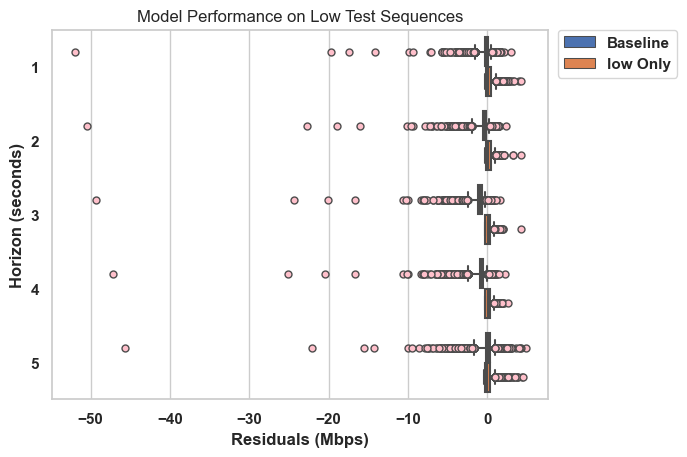

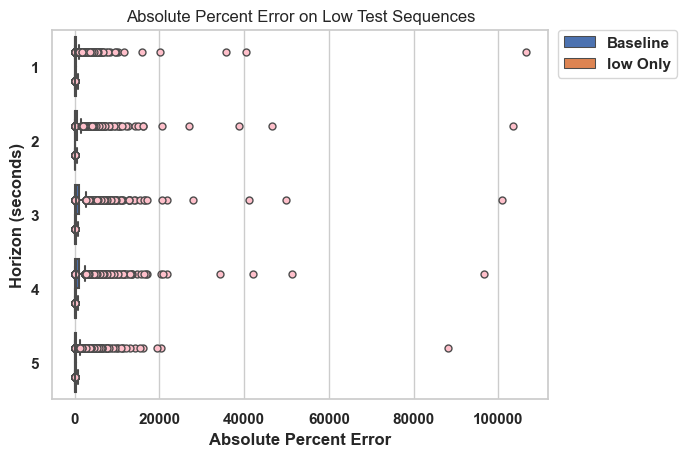

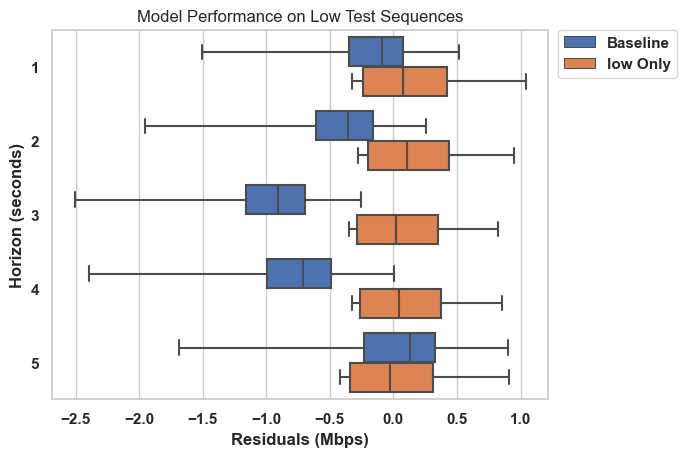

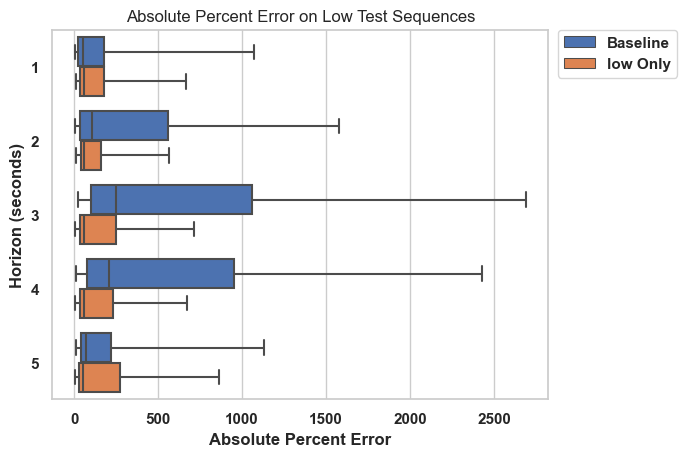

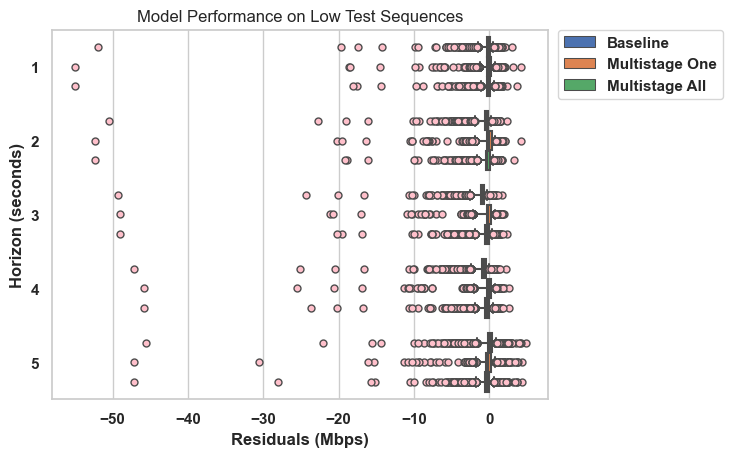

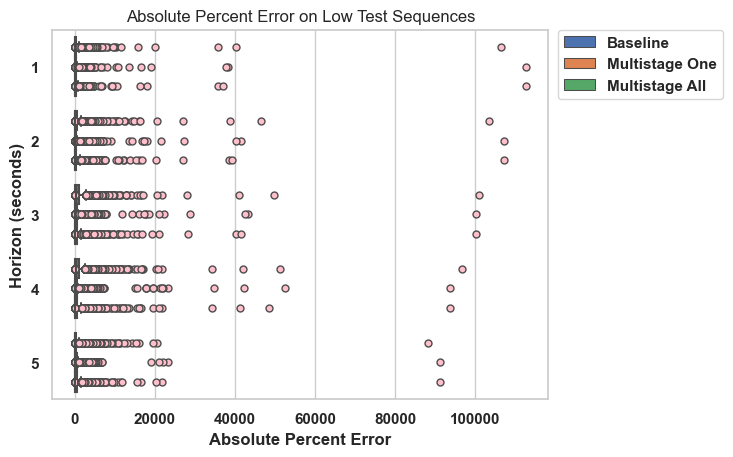

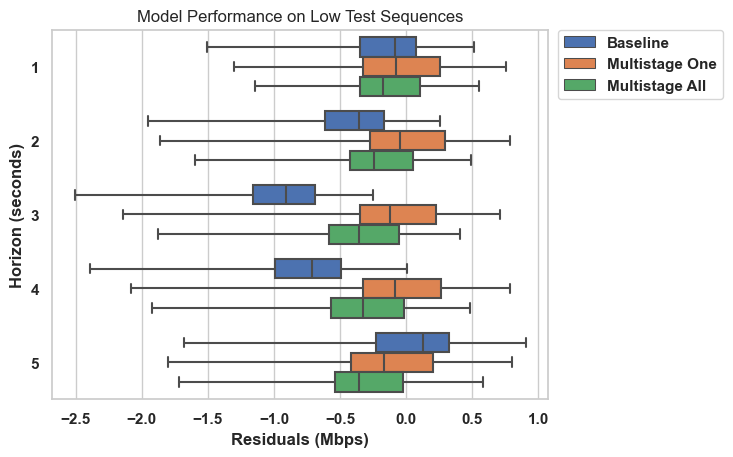

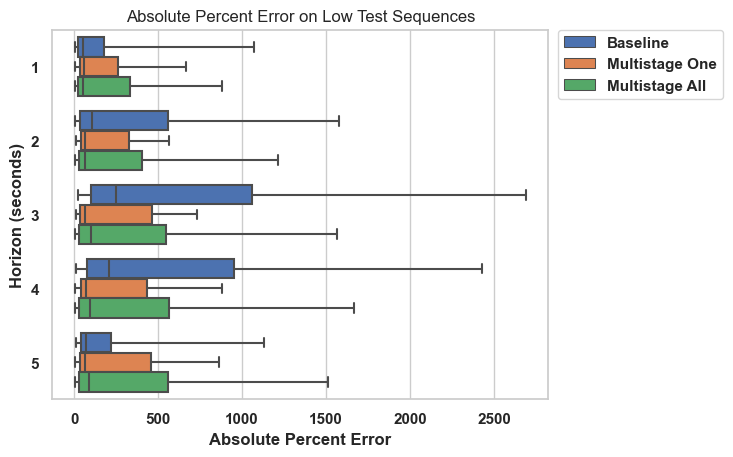


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.58 & 1.311 & 555.456 & 2.054 & 0.734\\
\hline
Multistage One & -0.243 & 1.316 & 384.505 & 1.792 & 0.577\\
\hline
Multistage All & -0.388 & 1.237 & 443.395 & 1.68 & 0.555\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of low Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.58 & 1.311 & 555.456 & 2.054 & 0.734\\
\hline
low Only & 0.125 & 0.445 & 186.807 & 0.214 & 0.344\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


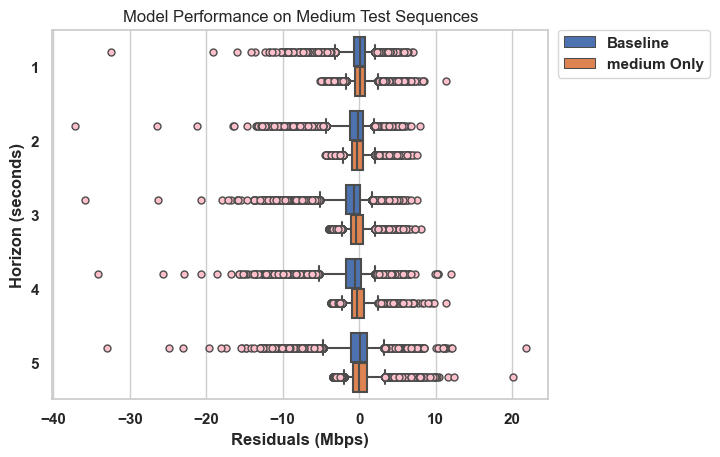

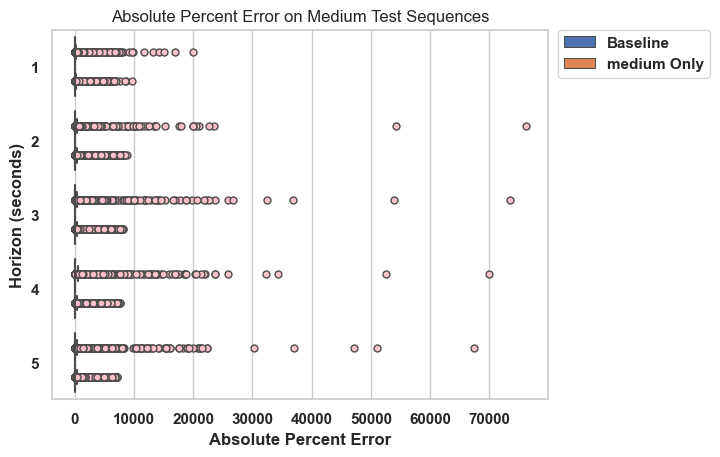

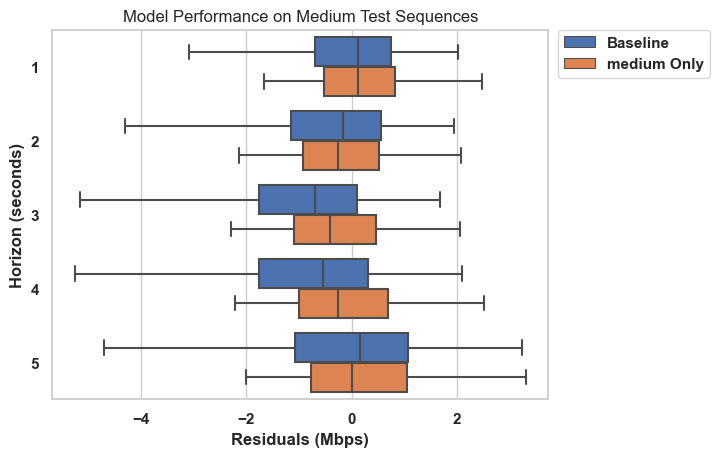

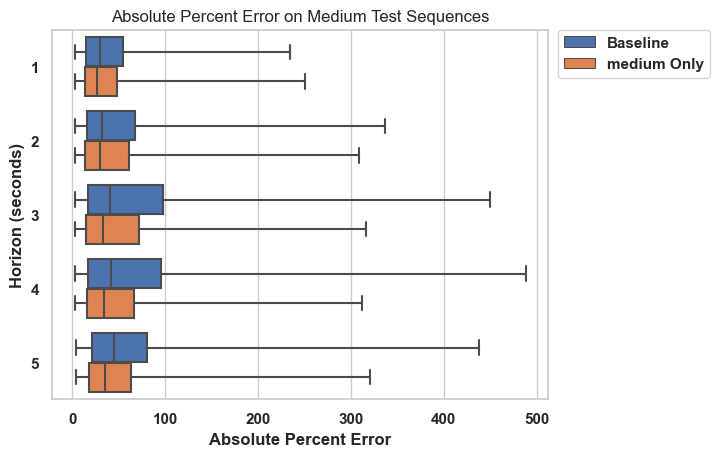

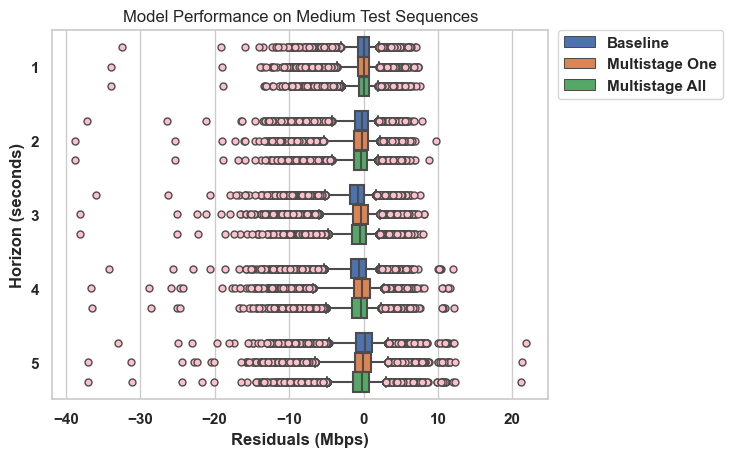

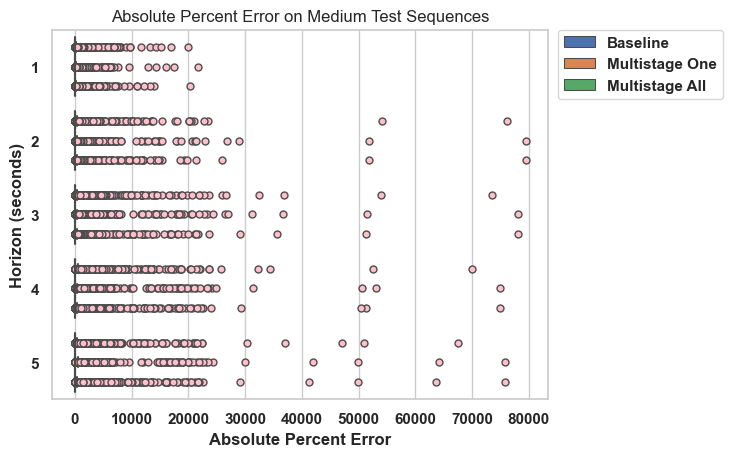

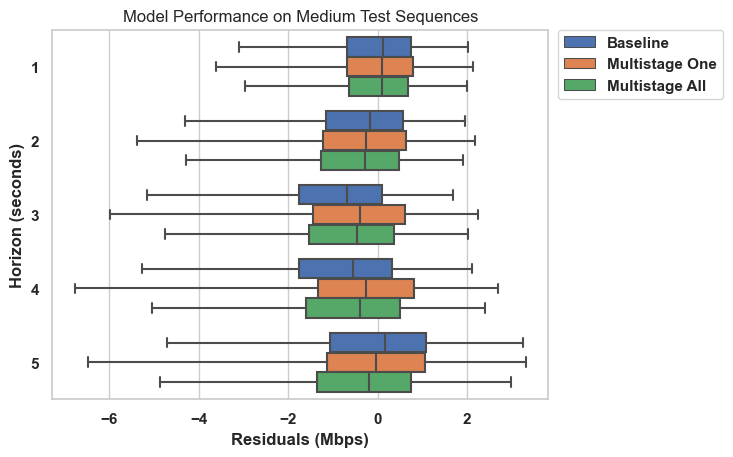

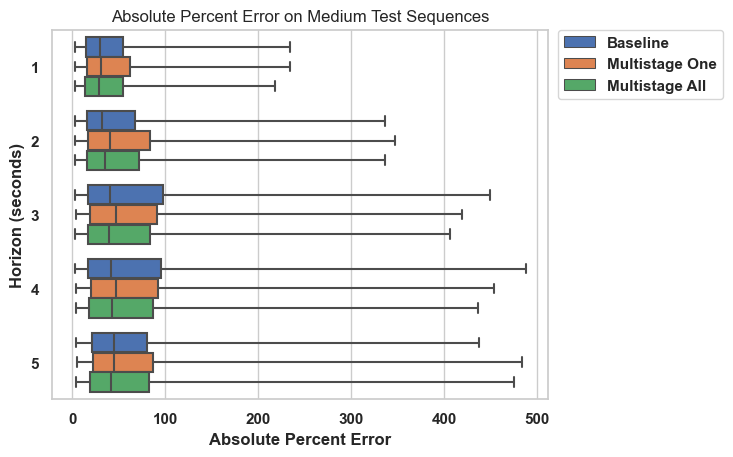


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.565 & 2.278 & 200.475 & 5.51 & 1.491\\
\hline
Multistage One & -0.542 & 2.564 & 200.171 & 6.866 & 1.628\\
\hline
Multistage All & -0.548 & 2.244 & 192.151 & 5.335 & 1.461\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of medium Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.565 & 2.278 & 200.475 & 5.51 & 1.491\\
\hline
medium Only & -0.011 & 1.441 & 133.059 & 2.078 & 1.064\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


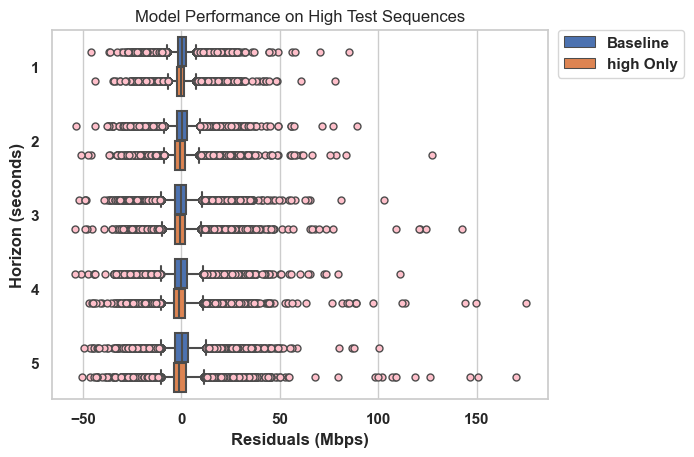

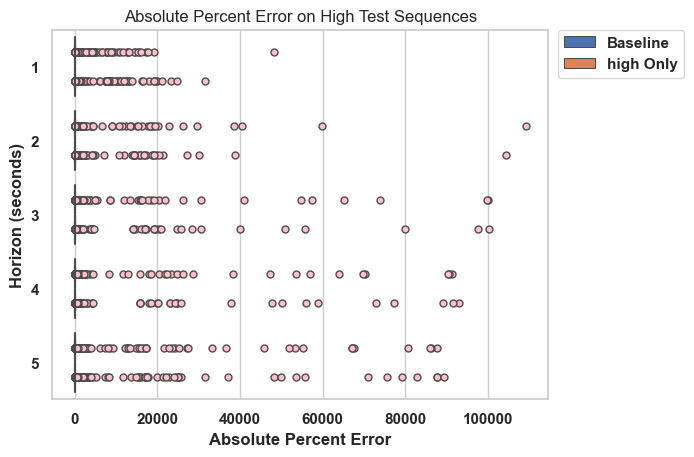

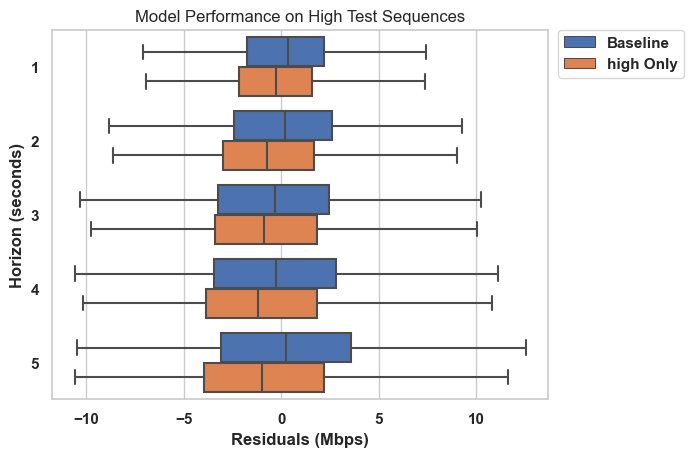

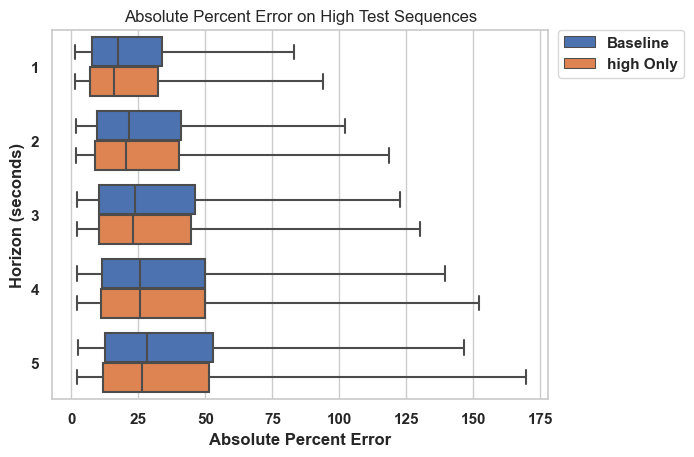

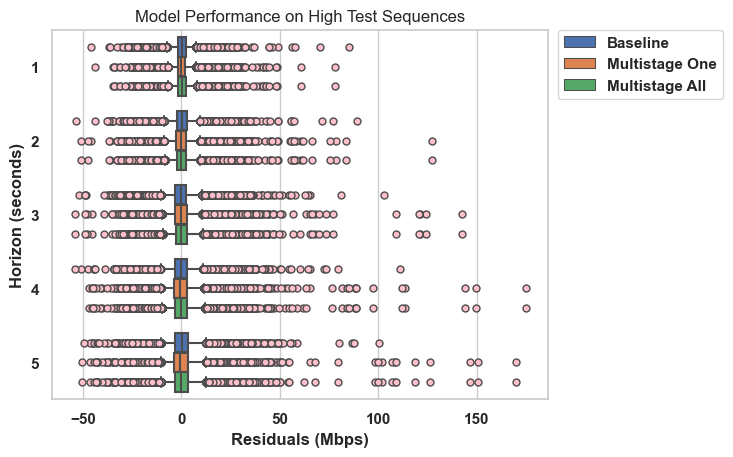

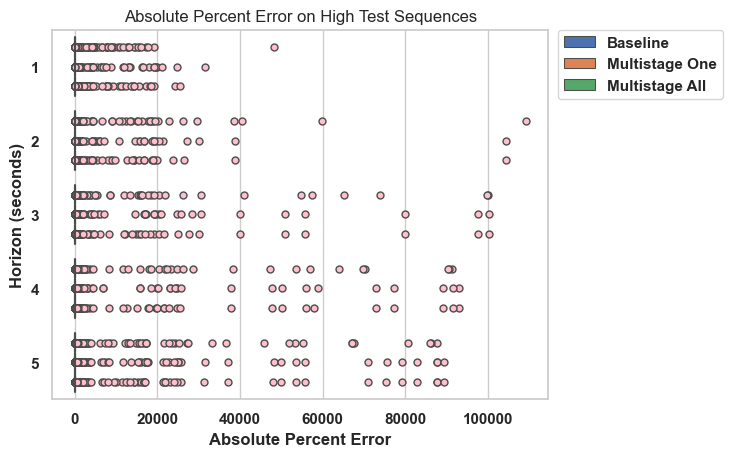

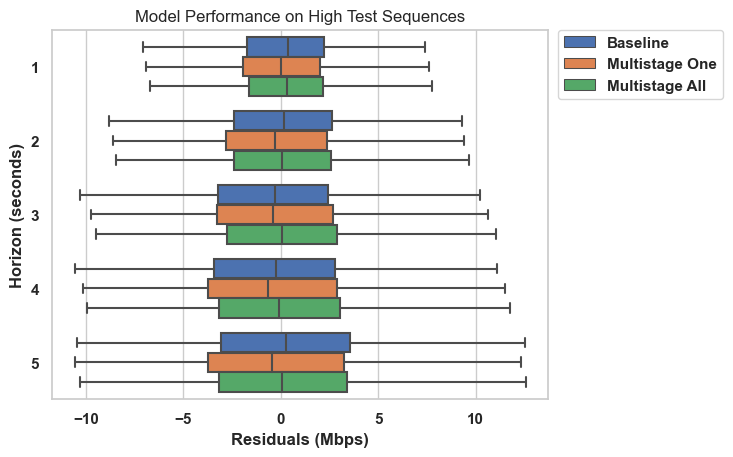

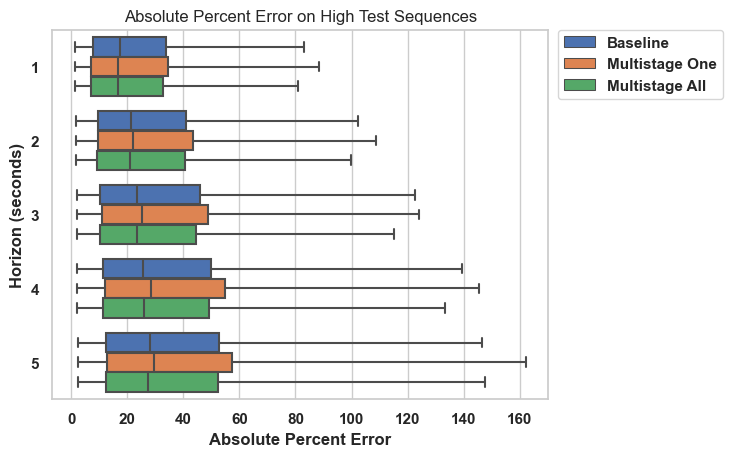


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 0.13 & 6.643 & 93.39 & 44.149 & 4.286\\
\hline
Multistage One & 0.047 & 7.003 & 93.562 & 49.051 & 4.374\\
\hline
Multistage All & 0.366 & 6.958 & 89.418 & 48.547 & 4.277\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of high Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 0.13 & 6.643 & 93.39 & 44.149 & 4.286\\
\hline
high Only & -0.371 & 6.844 & 99.36 & 46.983 & 4.206\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


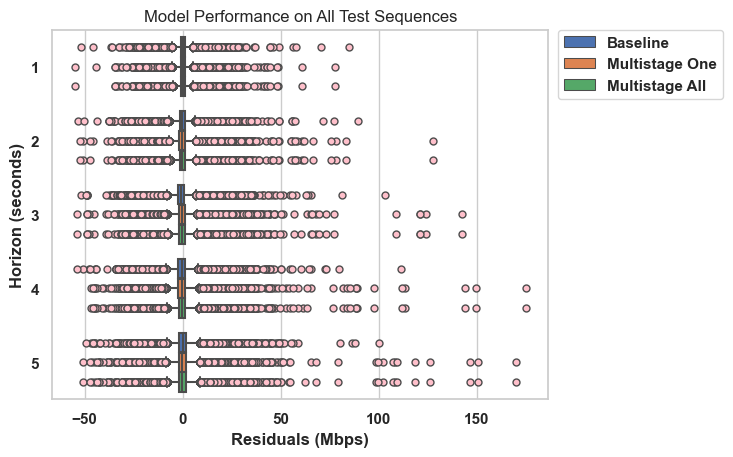

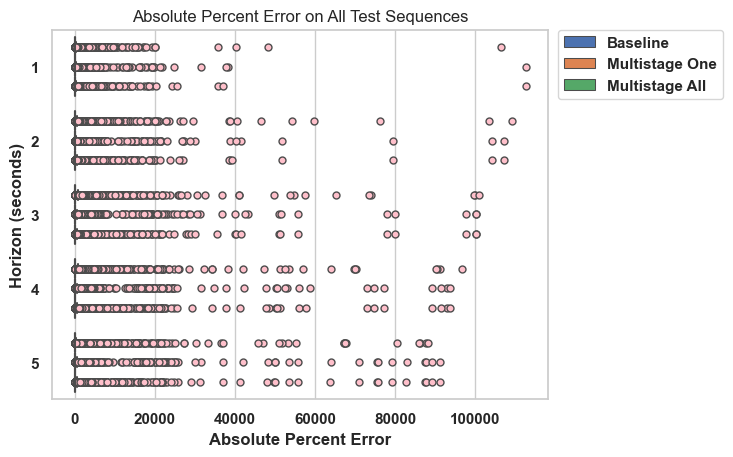

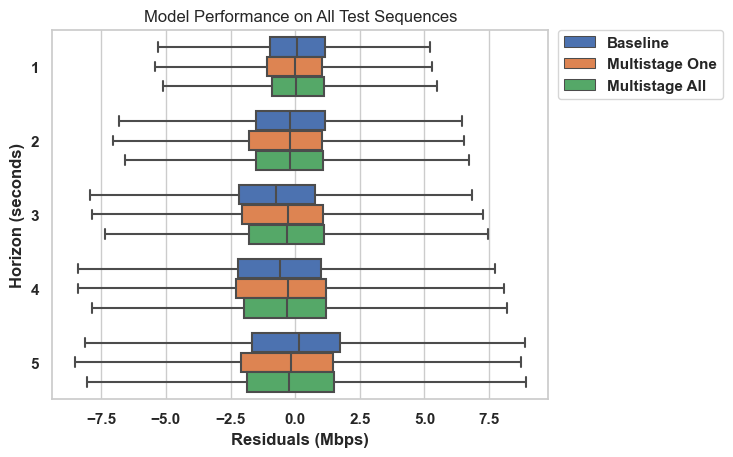

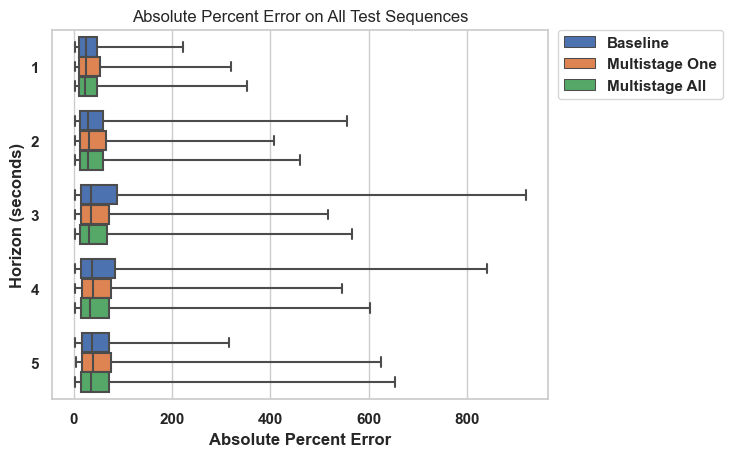

Residuals of All Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.185 & 5.12 & 194.793 & 26.248 & 2.915\\
\hline
Multistage One & -0.173 & 5.411 & 169.163 & 29.312 & 2.981\\
\hline
Multistage All & -0.021 & 5.344 & 173.308 & 28.559 & 2.874\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}
Classification Report:
               precision    recall  f1-score   support

         low       0.76      0.82      0.79      3995
      medium       0.74      0.74      0.74      7991
        high       0.92      0.90      0.91     14657

    accuracy                           0.84     26643
   macro avg       0.81      0.82      0.81     26643
weighted avg       0.84      0.84      0.84     26643



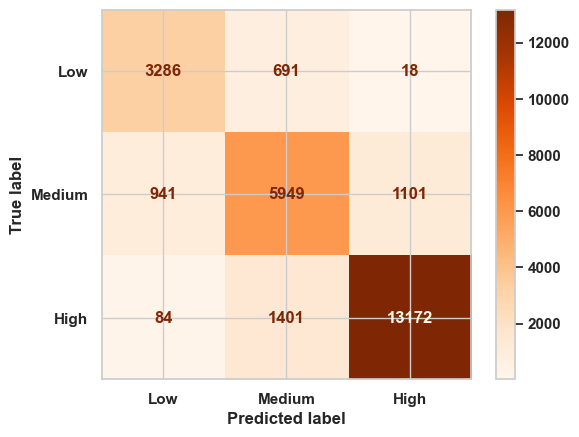

In [17]:
carry_out_analysis("univariate", "Univariate")

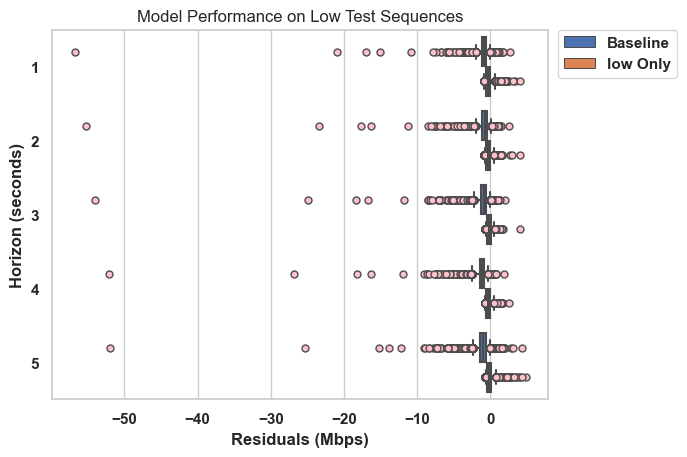

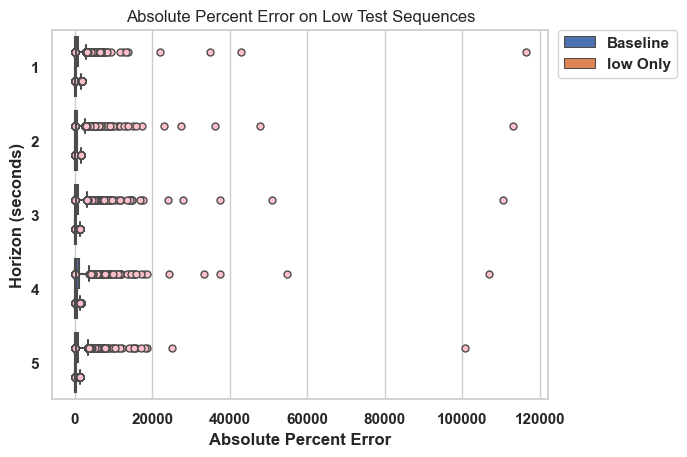

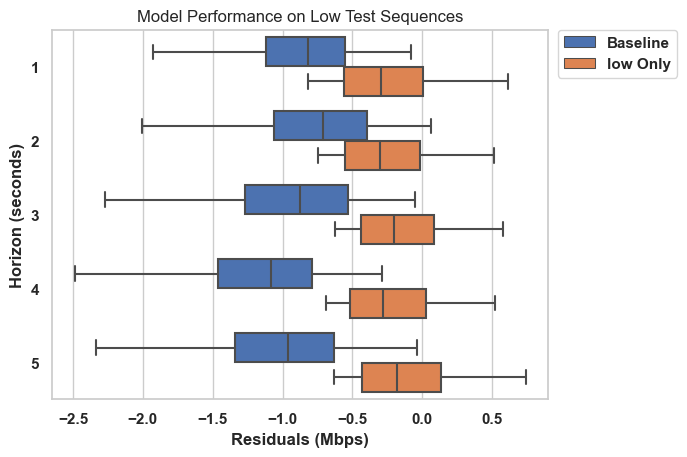

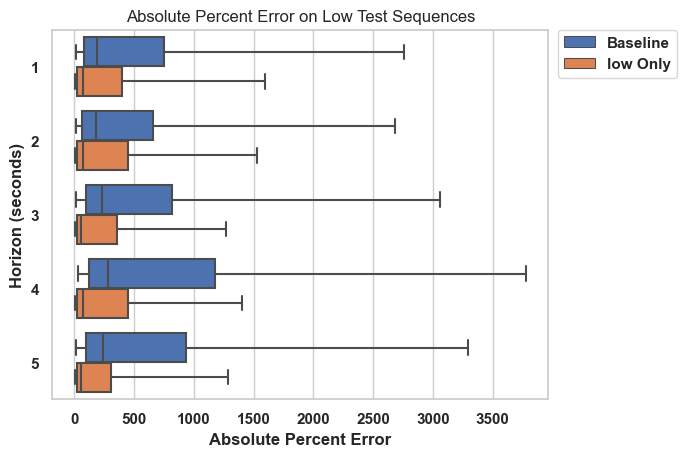

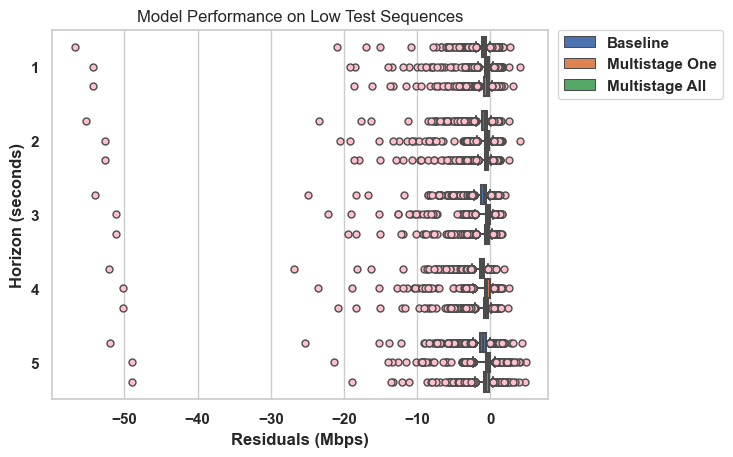

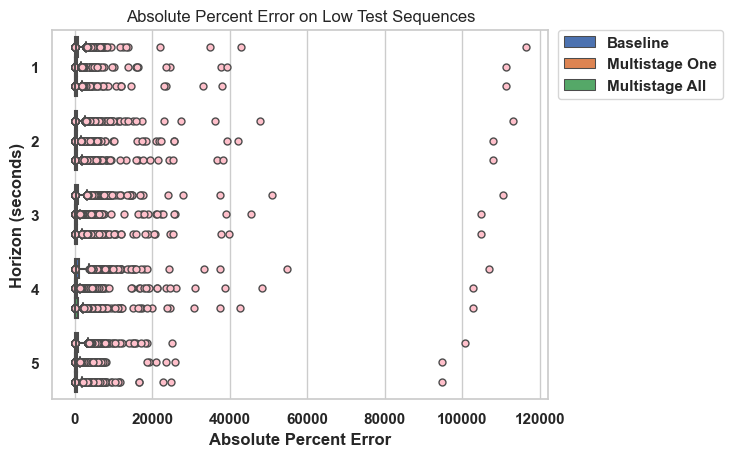

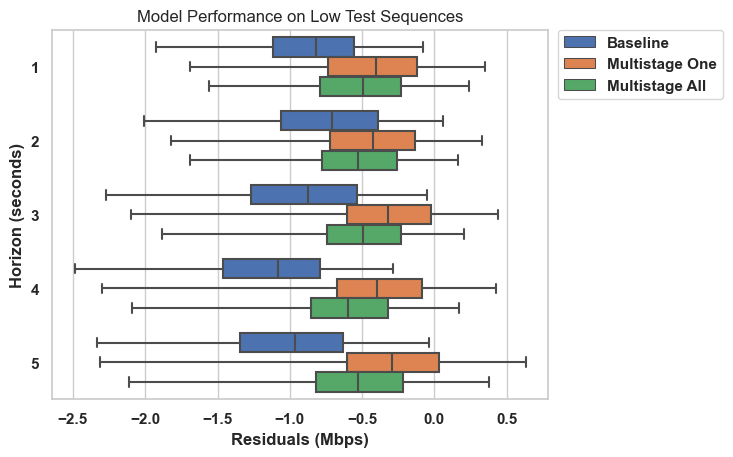

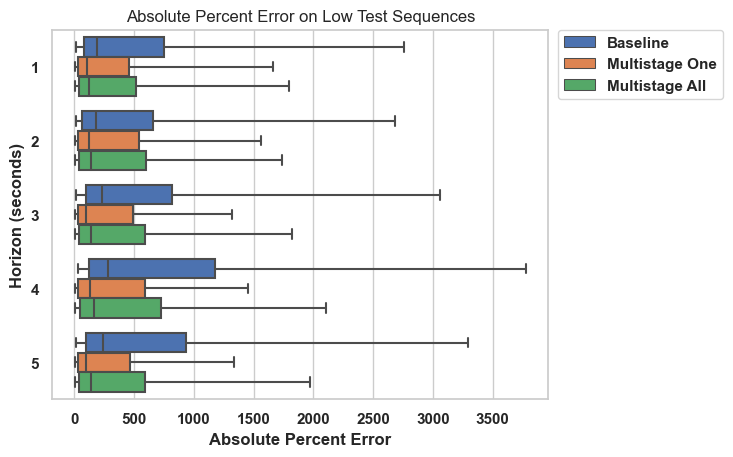


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -1.022 & 1.28 & 816.174 & 2.683 & 1.051\\
\hline
Multistage One & -0.522 & 1.315 & 513.378 & 2.002 & 0.657\\
\hline
Multistage All & -0.653 & 1.226 & 579.991 & 1.929 & 0.72\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of low Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -1.022 & 1.28 & 816.174 & 2.683 & 1.051\\
\hline
low Only & -0.182 & 0.438 & 310.942 & 0.225 & 0.384\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


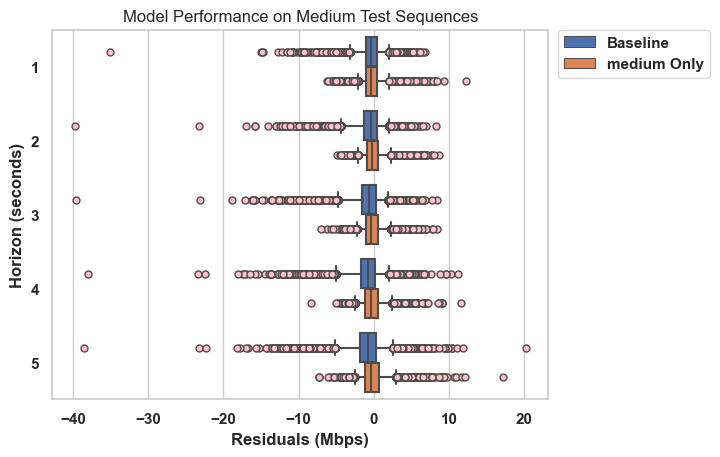

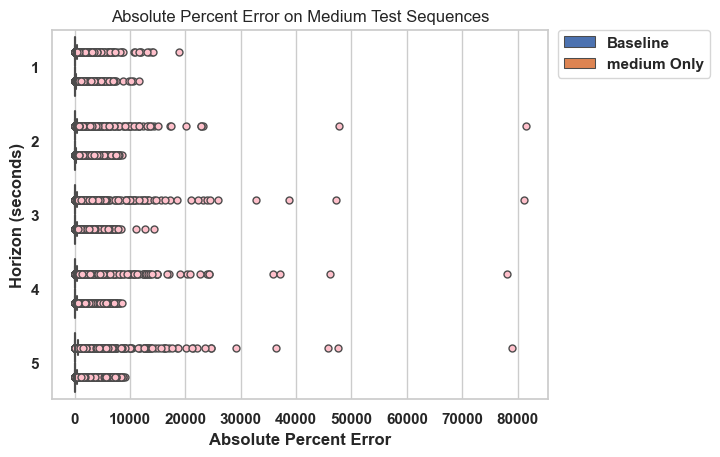

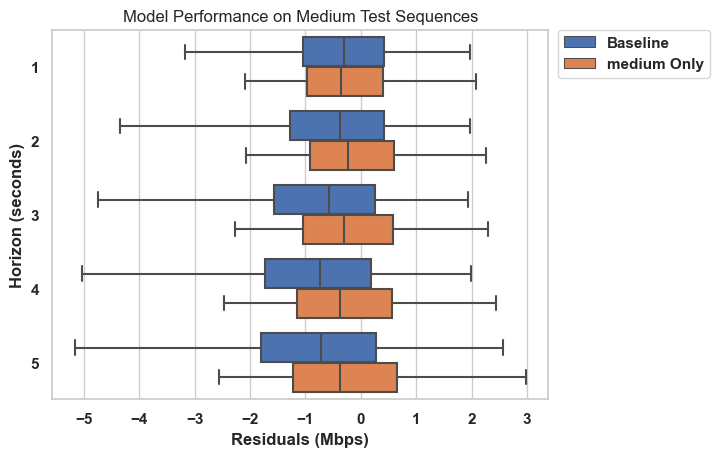

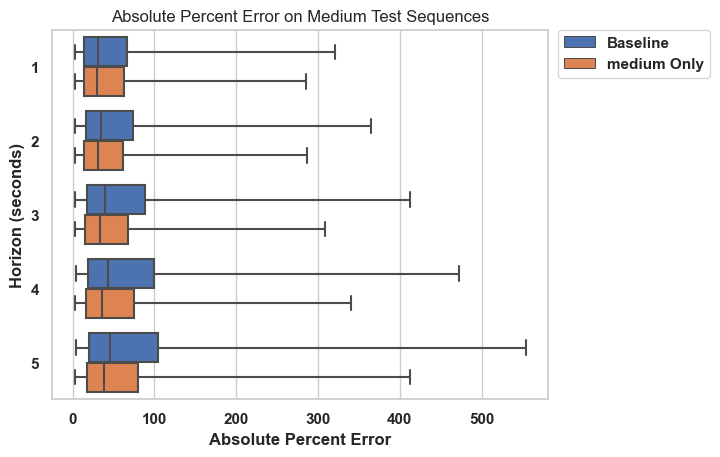

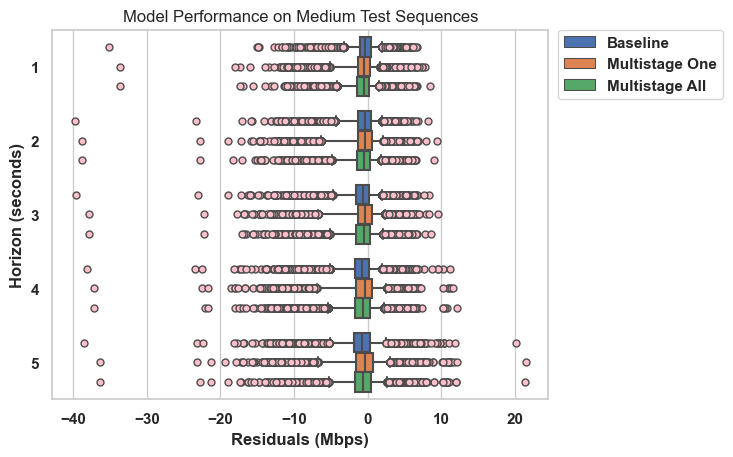

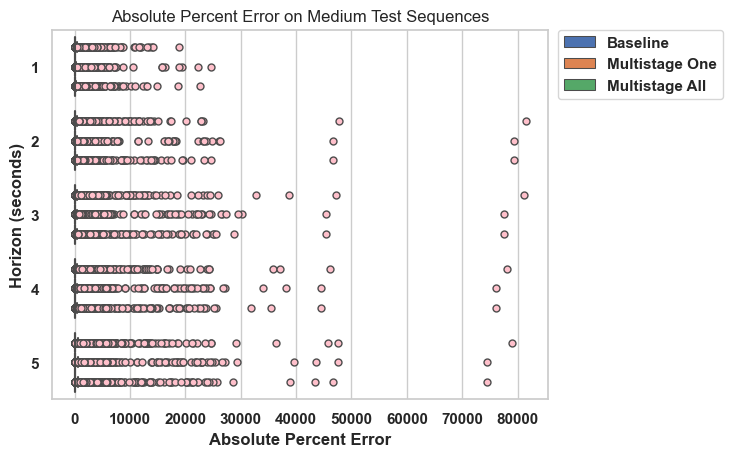

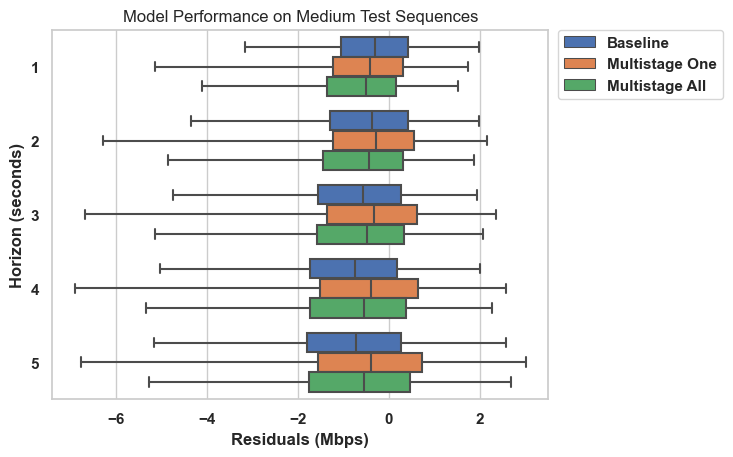

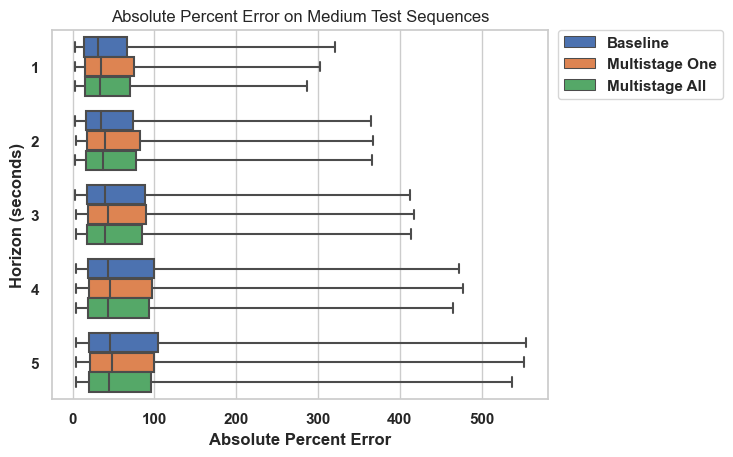


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.766 & 2.186 & 208.283 & 5.365 & 1.501\\
\hline
Multistage One & -0.793 & 2.648 & 211.935 & 7.643 & 1.716\\
\hline
Multistage All & -0.831 & 2.307 & 204.82 & 6.014 & 1.572\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of medium Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.766 & 2.186 & 208.283 & 5.365 & 1.501\\
\hline
medium Only & -0.178 & 1.476 & 138.987 & 2.21 & 1.113\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


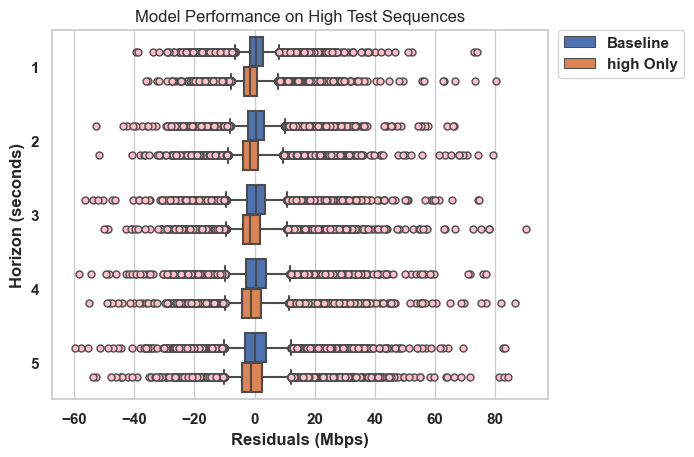

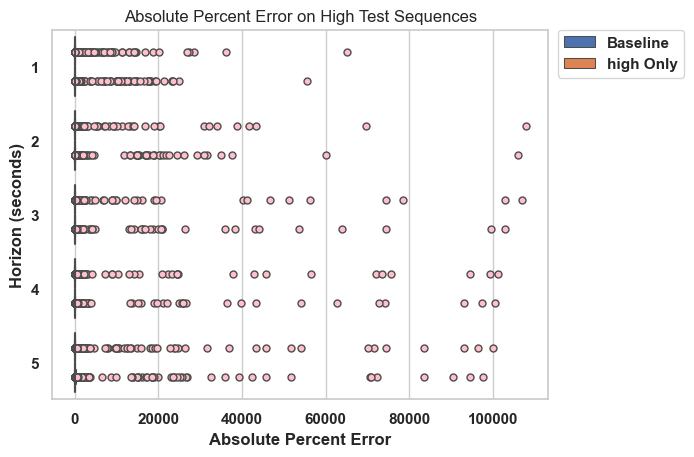

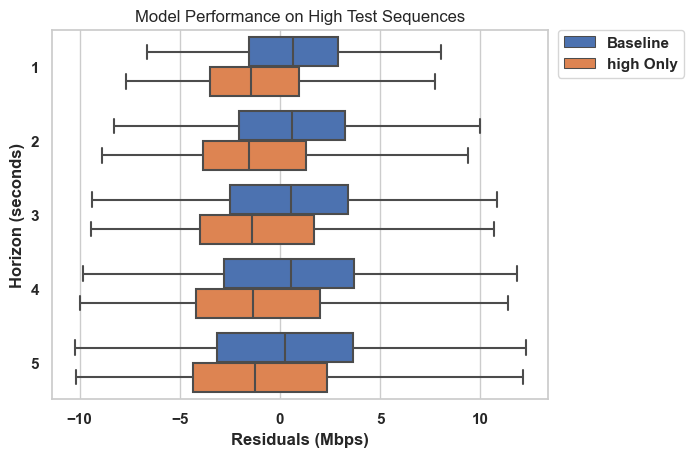

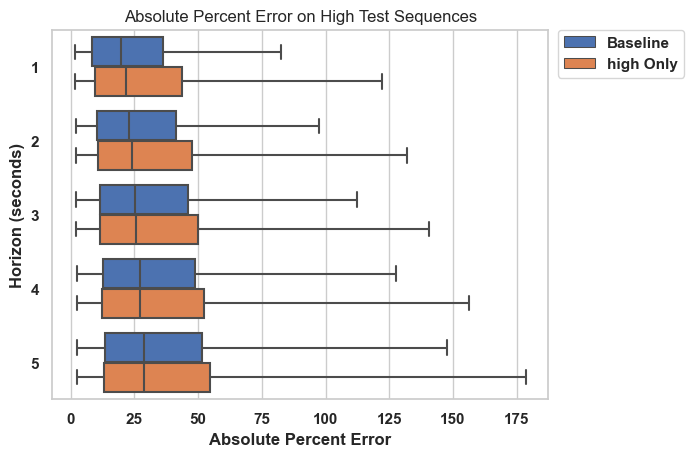

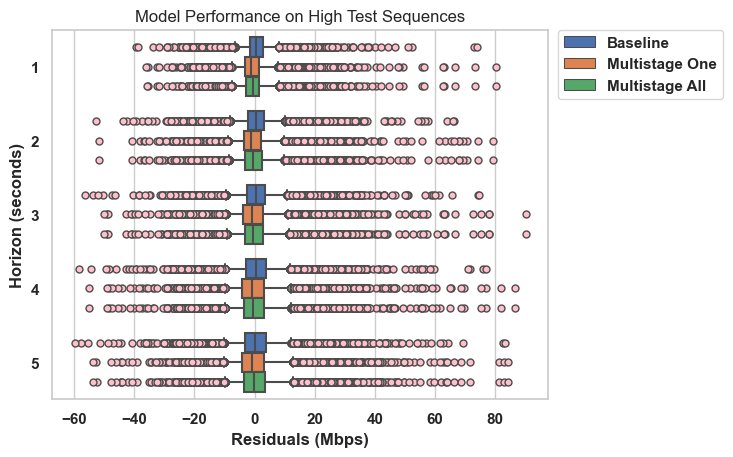

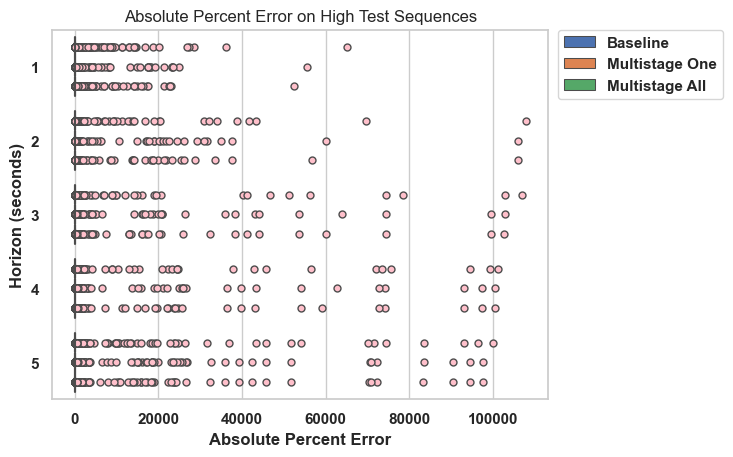

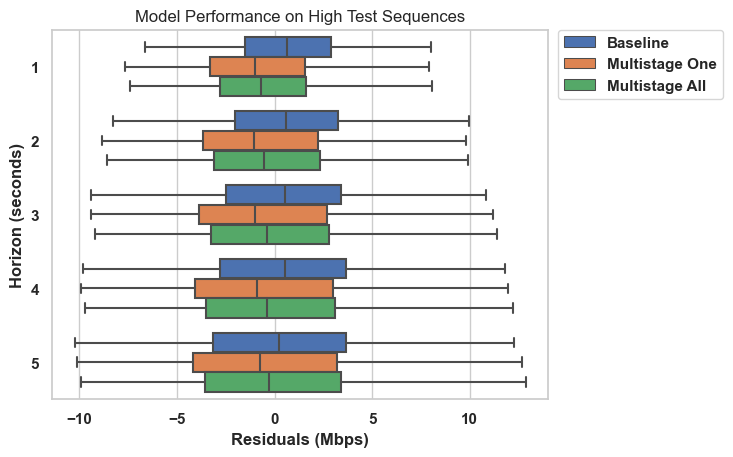

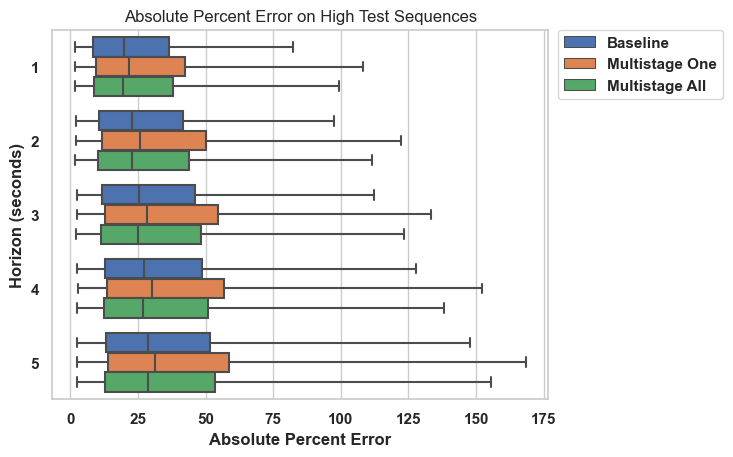


MULTISTAGE

\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 0.658 & 6.594 & 96.006 & 43.916 & 4.366\\
\hline
Multistage One & -0.271 & 6.884 & 101.505 & 47.468 & 4.63\\
\hline
Multistage All & 0.069 & 6.795 & 95.285 & 46.177 & 4.436\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


Residuals of high Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & 0.658 & 6.594 & 96.006 & 43.916 & 4.366\\
\hline
high Only & -0.7 & 6.71 & 107.985 & 45.517 & 4.495\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}


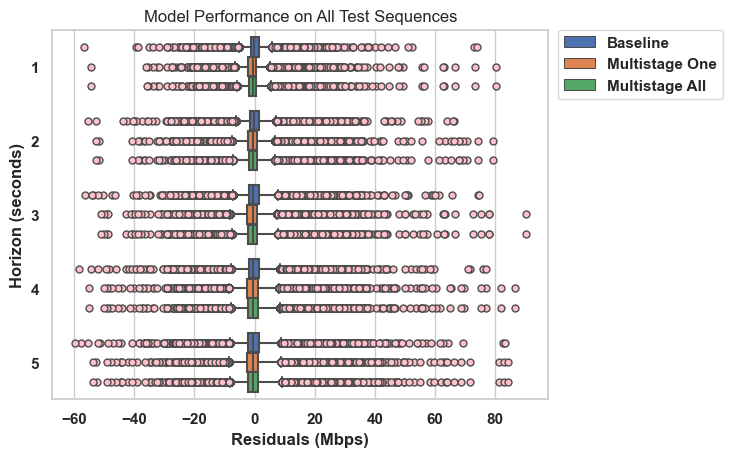

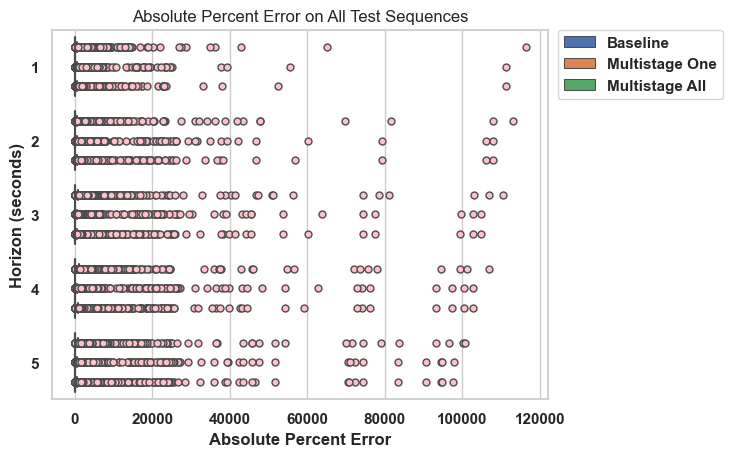

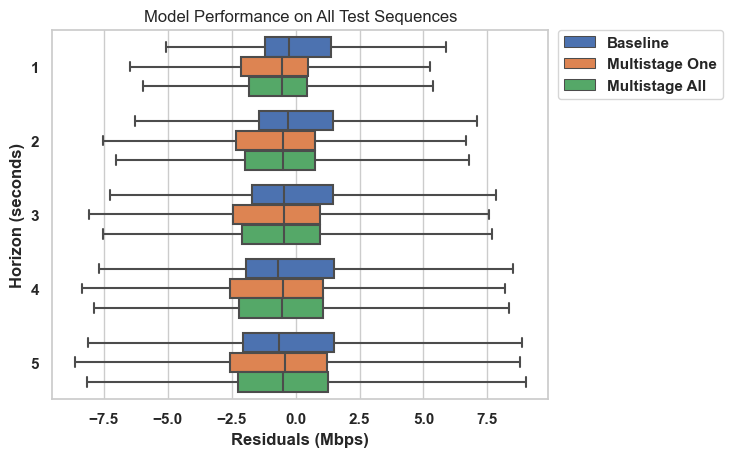

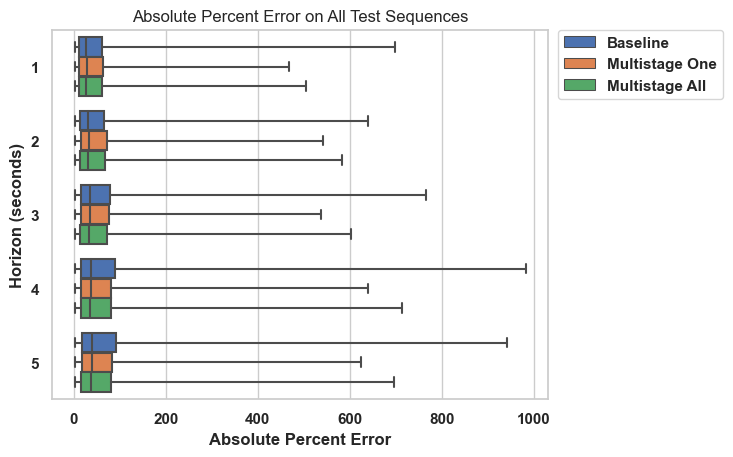

Residuals of All Sequences Test Set
\begin{table}[!htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
{Model} & {Mean Resids (Mbps)} & {Resids std (Mbps)} & {MAPE} & {MSE (Mbps)} & {MAE (Mbps)}\\
\hline
Baseline & -0.021 & 5.116 & 237.667 & 26.171 & 3.01\\
\hline
Multistage One & -0.465 & 5.338 & 196.384 & 28.706 & 3.16\\
\hline
Multistage All & -0.309 & 5.235 & 200.817 & 27.496 & 3.02\\
\hline
\end{tabular}
\label{tab:train_test_dist}
\end{table}
Classification Report:
               precision    recall  f1-score   support

         low       0.77      0.82      0.79      3995
      medium       0.74      0.75      0.74      7991
        high       0.92      0.90      0.91     14657

    accuracy                           0.84     26643
   macro avg       0.81      0.82      0.81     26643
weighted avg       0.84      0.84      0.84     26643



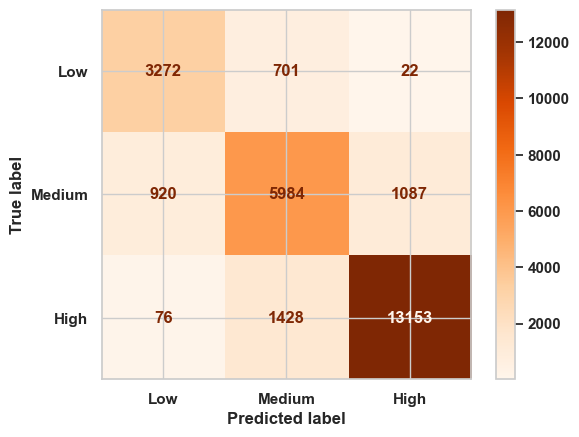

In [18]:
carry_out_analysis("Multivariate", "Multivariate")

# Classifier Error Analysis

### Univariate

In [21]:
true, pred = import_data(model_name="univariate_multiAll_classifier")
x = np.load(TEST_FOLDER+"univariate_test_x.npy").squeeze()

In [22]:
x.shape

(26643, 10)

In [26]:
create_csv(x, true, pred)

In [14]:
true, pred = import_data(model_name="univariate_multiAll_classifier")
true = np.argmax(true, axis=-1)
pred = np.argmax(pred, axis=-1)
conf_matrix = confusion_matrix(true, pred)
# create a dictionary to map class names
class_names = {0: "low", 1: "medium", 2: "high"}
# map the class names
true_names = [class_names[x] for x in true]
pred_names = [class_names[x] for x in pred]
report = classification_report(true_names, pred_names, labels=["low", "medium", "high"])
print("Classification Report:\n",report)

Classification Report:
               precision    recall  f1-score   support

         low       0.75      0.84      0.79      3995
      medium       0.74      0.74      0.74      7991
        high       0.92      0.90      0.91     14657

    accuracy                           0.84     26643
   macro avg       0.81      0.82      0.81     26643
weighted avg       0.84      0.84      0.84     26643



In [17]:
x = np.load("C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Testing/univariate_classifier_test_x.npy")
y = np.load("C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Testing/univariate_test_y.npy")

In [19]:
df = pd.DataFrame()
df["true"] = true_names
df["pred"] = pred_names

In [36]:
print(conf_matrix)

[[ 3344   632    19]
 [ 1010  5924  1057]
 [   94  1438 13125]]


In [20]:
low_as_med = df[(df["true"]=="low") & (df["pred"]=="medium")].index.to_list()
med_as_low = df[(df["true"]=="medium") & (df["pred"]=="low")].index.to_list()
low_med_boundary = low_as_med + med_as_low

In [51]:
tp_low_med_boundary = y[low_med_boundary,:]
tp_low_med_boundary = tp_low_med_boundary/1024
low_med_bound_means = np.mean(tp_low_med_boundary, axis=1)
low_med_bound_std = np.std(tp_low_med_boundary, axis=1)
mean_val = [np.mean(low_med_bound_means)]*(low_med_bound_means.shape[0])
plt.plot(low_med_bound_means)
plt.plot(mean_val, color="red")

In [61]:
mean_val = [np.mean(low_med_bound_means)]*(low_med_bound_means.shape[0])
plt.plot(low_med_bound_means)
plt.plot(mean_val, color="red")

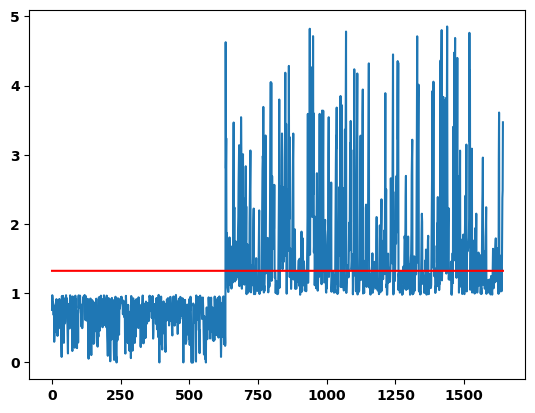

In [62]:
plt.plot(low_med_bound_means)
plt.plot(mean_val, color="red")

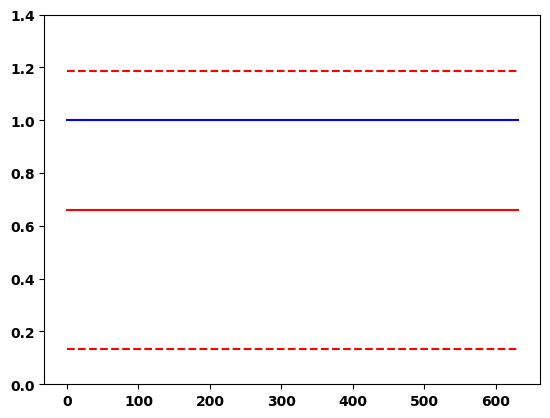

In [31]:
low_bound = y[low_as_med,:]/1024
low_mean = np.mean(low_bound)
low_std = np.std(low_bound)
mean_vector = [low_mean]*low_bound.shape[0]
std_vector = [low_std]*low_bound.shape[0]
std_vector_up = [low_std+low_mean]*low_bound.shape[0]
std_vector_down = [low_mean-low_std]*low_bound.shape[0]
plt.ylim(0,1.4)
plt.plot([1]*low_bound.shape[0], linestyle="-", color="blue")
plt.plot(mean_vector, color="red")
plt.plot(std_vector_up, linestyle="--", color="red")
plt.plot(std_vector_down, linestyle="--", color="red")

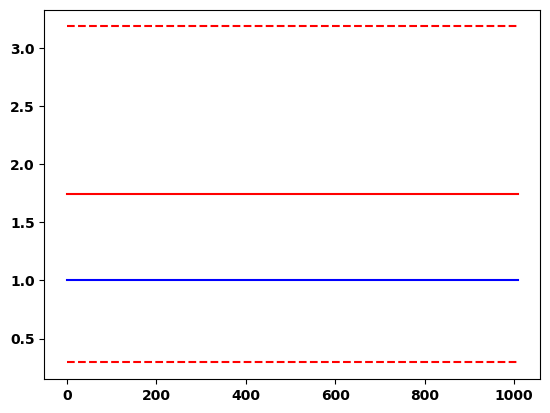

In [33]:
med_bound = y[med_as_low,:]/1024
med_mean = np.mean(med_bound)
med_std = np.std(med_bound)
mean_vector = [med_mean]*med_bound.shape[0]
std_vector = [med_std]*med_bound.shape[0]
std_vector_up = [med_std+med_mean]*med_bound.shape[0]
std_vector_down = [med_mean-med_std]*med_bound.shape[0]
#plt.ylim(0,1.4)
plt.plot([1]*med_bound.shape[0], linestyle="-", color="blue")
plt.plot(mean_vector, color="red")
plt.plot(std_vector_up, linestyle="--", color="red")
plt.plot(std_vector_down, linestyle="--", color="red")

INFO:tensorflow:Assets written to: C:\Users\Killian\AppData\Local\Temp\tmpzll0onz2\assets


INFO:tensorflow:Assets written to: C:\Users\Killian\AppData\Local\Temp\tmpzll0onz2\assets


ConverterError: c:\Users\Killian\miniconda3\envs\tf\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
c:\Users\Killian\miniconda3\envs\tf\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False
